In [15]:
%pip install unidecode

In [28]:
import pandas as pd
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch


In [17]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [18]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
path = Path("/content/drive/MyDrive/Colab Notebooks/filtered_news_dataset_single_company.csv")

In [20]:
df = pd.read_csv(path)

In [21]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb


In [40]:
import re

# --- SWISS-ADJUSTED MULTILINGUAL BUSINESS / FINANCE / INVENTION DICTIONARIES ---

FIN = {
    "de": (
        r"(uebernahm|uebernimmt|uebernahme|fusion|verkauf|"
        r"kauf|gewinn|verlust|umsatz|ertrag|prognose|guidance|dividende|"
        r"auftrag|bestellung|vertrag|investition|ipo|boerse|aktie|kurs|"
        r"quartal|geschaeftsjahr|bilanz|marge|cash ?flow|rating|"
        r"anleihe|refinanzierung|generalversammlung|verwaltungsrat|"
        r"vr|geschaeftsleitung|ceo|cfo|sparte|bereich|abspaltung|"
        r"holding|notierung|kotierung|gewinnwarnung|stellenabbau|"
        r"personalabbau|ueberkapazitaet|fusioniert|uebernimmt|"
        r"reingewinn|umsatzwachstum|marktanteil|export|konjunktur|"
        r"bundesbank|snb|nationalbank|zins|zinspolitik|inflation|"
        r"gdp|wirtschaftswachstum|"
        # --- business / operations ---
        r"unternehmen|firma|konzern|tochter|tochtergesellschaft|"
        r"joint[- ]venture|kooperation|partnerschaft|allianz|"
        r"lieferkette|supply[- ]?chain|werk|fabrik|standort|"
        r"produktion|produktionslinie|kapazitaet|kapazitäts|"
        r"ausbau|hochfahren|skalierung|verlagerung|verlagerungs|"
        r"produkteinfuehrung|produkteinführung|markteinfuehrung|markteinführung|"
        r"produktlaunch|produktstart|portfolio|strategie|strategisch|"
        r"lizenz|lizenzierung|lizenzvertrag|kooperationsvertrag|"
        r"absichtserklaerung|absichtserklärung|mou|loi|"
        r"auftragseingang|auftragsbestand|backlog|ausschreibung|tender|"
        # --- innovation / R&D ---
        r"patent|schutzrecht|geistiges eigentum|ip|"
        r"innovation|innovations|forschung|entwicklung|f&e|r&d|"
        r"prototyp|pilotprojekt|technologie|ki|ai|robotik|automatisierung)"
    ),

    "fr": (
        r"(acquisition|rachat|cession|fusion|vente|achat|benefice|perte|"
        r"chiffre d'affaires|revenu|marge|dividende|commande|contrat|"
        r"investissement|introduction en bourse|ipo|bourse|action|cours|"
        r"trimestre|exercice|rapport annuel|perspectives|flux de tresorerie|"
        r"notation|obligation|refinancement|assemblee generale|"
        r"conseil d'administration|scission|secteur|filiale|filiales|"
        r"restructuration|reduction d'effectifs|plan social|"
        r"banque nationale suisse|bns|taux d'interet|inflation|"
        r"croissance economique|"
        # --- business / operations ---
        r"entreprise|societe|société|groupe|coentreprise|joint[- ]venture|"
        r"partenariat|alliance|chaine d'approvisionnement|chaîne d'approvisionnement|"
        r"supply[- ]?chain|usine|site|implantation|production|"
        r"ligne de production|capacite|capacité|augmentation de capacité|extension|"
        r"lancement de produit|mise sur le marche|mise sur le marché|"
        r"portefeuille|strategie|stratégie|licence|licensing|accord de licence|"
        r"accord de partenariat|protocole d'accord|mou|loi|"
        r"prise de commande|carnet de commandes|backlog|appel d'offres|"
        # --- innovation / R&D ---
        r"brevet|propriete intellectuelle|propriété intellectuelle|pi|"
        r"innovation|recherche|developpement|développement|r&d|"
        r"prototype|projet pilote|technologie|ia|robotique|automatisation)"
    ),

    "en": (
        r"(acquisition|merger|divesti|spin[- ]off|sale|buy|profit|loss|"
        r"revenue|earnings|ebit|margin|guidance|dividend|order|contract|"
        r"investment|ipo|listing|exchange|stock|share|price|quarter|"
        r"annual report|outlook|cash ?flow|bond|refinanc|rating|capital "
        r"(raise|market)|buyback|share repurchase|board|agm|subsidiary|"
        r"mergers and acquisitions|layoffs|swiss national bank|interest rate|inflation|"
        # --- business / operations ---
        r"company|firm|corporation|conglomerate|subsidiary|"
        r"joint[- ]venture|partnership|alliance|"
        r"supply[- ]?chain|factory|plant|site|facility|"
        r"production|manufactur|assembly line|capacity|ramp[- ]?up|scale[- ]?up|"
        r"relocation|footprint|product (launch|release|introduction)|"
        r"go[- ]to[- ]market|portfolio|strategy|strategic|license|licensing|licence|"
        r"partnership agreement|memorandum of understanding|mou|letter of intent|loi|"
        r"order intake|order backlog|backlog|tender|request for proposal|rfp|"
        # --- innovation / R&D ---
        r"patent|ip|intellectual property|innovation|research and development|"
        r"research|development|r&d|prototype|pilot project|technology|"
        r"ai|artificial intelligence|robotics|automation)"
    ),

    "it": (
        r"(acquisizione|fusione|cessione|vendita|acquisto|utile|perdita|"
        r"ricavi|fatturato|margine|dividendo|ordine|contratto|"
        r"investimento|ipo|borsa|azione|prezzo|trimestre|bilancio|"
        r"relazione annuale|flusso di cassa|obbligazione|rifinanziamento|"
        r"rating|aumento di capitale|assemblea generale|cda|scissione|filiale|"
        r"riduzione del personale|banca nazionale svizzera|tasso di interesse|inflazione|"
        # --- business / operations ---
        r"impresa|azienda|societa|società|gruppo|controllata|joint[- ]venture|"
        r"partenariato|alleanza|catena di fornitura|supply[- ]?chain|"
        r"stabilimento|impianto|sede|produzione|linea di produzione|capacita|capacità|"
        r"aumento di capacita|aumento di capacità|espansione|lancio (di prodotto)?|"
        r"introduzione sul mercato|go[- ]to[- ]market|portafoglio|strategia|strategico|"
        r"licenza|licensing|accordo di partenariato|memorandum d'intesa|mou|"
        r"lettera di intenti|loi|acquisizione ordini|portafoglio ordini|backlog|"
        r"gara|appalto|"
        # --- innovation / R&D ---
        r"brevetto|proprieta intellettuale|proprietà intellettuale|pi|"
        r"innovazione|ricerca|sviluppo|ricerca e sviluppo|r&d|"
        r"prototipo|progetto pilota|tecnologia|ia|intelligenza artificiale|"
        r"robotica|automazione)"
    ),
}


# --- NON-BUSINESS / NON-FINANCIAL DICTIONARY (same as your version) ---

NON = {
    "de": (
        r"(geboren|gestorben|nachruf|museum|ausstellung|kultur|musik|sport|"
        r"verein|jubilaeum|schule|universitaet|kirche|gemeinde|fest|feier|"
        r"portrait|biografie|wetter|unfall|brand|politik|gemeinderat|kanton|"
        r"strasse|verkehr|bauprojekt|wohnhaus|schueler|freizeit|tierpark)"
    ),
    "fr": (
        r"(ne|decede|necrologie|musee|exposition|culture|musique|sport|"
        r"association|jubile|ecole|universite|eglise|commune|fete|ceremonie|"
        r"portrait|biographie|meteo|accident|incendie|politique|commune|"
        r"rue|circulation|chantier|immeuble|etudiant|loisir|zoo)"
    ),
    "en": (
        r"(born|died|obituary|museum|exhibition|culture|music|sport|club|"
        r"anniversary|school|university|church|festival|ceremony|portrait|"
        r"biography|weather|accident|fire|politics|parliament|community|"
        r"street|traffic|construction|housing|education|leisure|animal park)"
    ),
    "it": (
        r"(nato|morto|necrologio|museo|mostra|cultura|musica|sport|"
        r"associazione|anniversario|scuola|universita|chiesa|festa|cerimonia|"
        r"ritratto|biografia|meteo|incidente|incendio|politica|comune|"
        r"strada|traffico|cantiere|edificio|studenti|tempo libero|zoo)"
    ),
}

# --- Compile all regex patterns ---
FIN_PAT = {k: re.compile(v, flags=re.IGNORECASE) for k, v in FIN.items()}
NON_PAT = {k: re.compile(v, flags=re.IGNORECASE) for k, v in NON.items()}


In [41]:
# --- normalization helper (re-use your existing text_norm if available) ---
def norm_txt(x: str) -> str:
    return re.sub(r"\s+", " ", unidecode(str(x)).lower()).strip()


def categorize_news(text: str, lang: str) -> str:
    """Return 'business', 'non-business', or 'uncertain'."""
    t = norm_txt(text)
    lang = (lang or "en").lower()
    if lang not in FIN_PAT:
        lang = "en"
    fin_hits = len(re.findall(FIN_PAT[lang], t))
    non_hits = len(re.findall(NON_PAT[lang], t))
    if fin_hits > 0 and non_hits == 0:
        return "financial"
    elif non_hits > 0 and fin_hits == 0:
        return "non-financial"
    else:
        return "uncertain"


df["topic_category"] = df.apply(lambda r: categorize_news(r["text_norm"], r["language"]), axis=1)

df["topic_category"].value_counts()

,count
topic_category,
uncertain,98433
financial,35506
non-financial,1496


In [43]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/swiss_news_with_category_manual.csv", index=False)
print("Saved -> swiss_news_with_category.csv")

Saved -> swiss_news_with_category.csv


In [42]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb,financial
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,uncertain
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb,uncertain
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb,uncertain
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb,financial


In [44]:
df_unc = df[df['topic_category'] == 'uncertain'].copy()

# 2) Build a classification text: headline (emphasized) + short content preview
def build_cat_text(row, max_chars=900):
    h = (row.get("head_clean") or "").strip()
    c = (row.get("content_clean") or "").strip()[:max_chars]
    return (h + ". " + h + ". " + c) if h else c  # repeat headline once to weight it

df_unc["cat_text"] = df_unc.apply(build_cat_text, axis=1).fillna("")

# 3) Quick sanity check
print("uncertain rows:", len(df_unc))
print(df_unc[["head_clean","cat_text"]].head(5))

uncertain rows: 98433
                                          head_clean                                           cat_text
1  ABB trennt sich von restlichem Stromnetz-Geschäft  ABB trennt sich von restlichem Stromnetz-Gesch...
2                   Fitness-Pionier übergibt an Sohn  Fitness-Pionier übergibt an Sohn. Fitness-Pion...
3                     Eine Kita in der eigenen Firma  Eine Kita in der eigenen Firma. Eine Kita in d...
5  Un pionnier de l’hydrogène débarque au Salon d...  Un pionnier de l’hydrogène débarque au Salon d...
6  Les investisseurs s’interrogent sur la santé f...  Les investisseurs s’interrogent sur la santé f...


In [45]:
model_id = "joeddav/xlm-roberta-large-xnli"
tok = AutoTokenizer.from_pretrained(model_id)
mod = AutoModelForSequenceClassification.from_pretrained(model_id)
clf = pipeline(
    "zero-shot-classification",
    model=mod, tokenizer=tok,
    device=0 if torch.cuda.is_available() else -1
)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [46]:
labels = ["financial", "non-financial"]
BATCH = 64

In [48]:
from tqdm.auto import tqdm

cat_top, p_fin, p_nonfin, cat_conf = [], [], [], []

for i in tqdm(range(0, len(df_unc), BATCH), total=(len(df_unc)//BATCH)+1, desc="Categorizing"):
    outs = clf(
        df_unc.iloc[i:i+BATCH]["cat_text"].tolist(),
        candidate_labels=labels,
        multi_label=False,
    )
    for r in outs:
        lab2score = {lab.lower(): float(sc) for lab, sc in zip(r["labels"], r["scores"])}
        pf  = lab2score.get("financial", 0.0)
        pnf = lab2score.get("non-financial", 0.0)
        top = "financial" if pf >= pnf else "non-financial"
        cat_top.append(top)
        p_fin.append(pf)
        p_nonfin.append(pnf)
        cat_conf.append(max(pf, pnf))



Categorizing:   0%|          | 0/1539 [00:00<?, ?it/s]

In [56]:
df_unc["cat_top"]   = cat_top
df_unc["p_fin"]     = p_fin
df_unc["p_nonfin"]  = p_nonfin
df_unc["cat_conf"]  = cat_conf


In [57]:
df_unc.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category,cat_text,cat_top,p_fin,p_nonfin,cat_conf
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,uncertain,ABB trennt sich von restlichem Stromnetz-Gesch...,financial,0.990769,0.009231,0.990769
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb,uncertain,Fitness-Pionier übergibt an Sohn. Fitness-Pion...,financial,0.504575,0.495425,0.504575
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb,uncertain,Eine Kita in der eigenen Firma. Eine Kita in d...,financial,0.746172,0.253828,0.746172
5,2019-03-06 23:00:00+00:00,fr,4847.0,Tribune de Genève,Un pionnier de l’hydrogène débarque au Salon d...,La voiture électrique est très présente à Pale...,abb.csv,ABB,2019,3,2019-03,un pionnier de l'hydrogene debarque au salon d...,abb,uncertain,Un pionnier de l’hydrogène débarque au Salon d...,non-financial,0.432272,0.567728,0.567728
6,2018-02-10 23:00:00+00:00,fr,572.0,Le Matin Dimanche,Les investisseurs s’interrogent sur la santé f...,Technologies Le groupe de techniques énergétiq...,abb.csv,ABB,2018,2,2018-02,les investisseurs s'interrogent sur la sante f...,abb,uncertain,Les investisseurs s’interrogent sur la santé f...,financial,0.930240,0.069760,0.930240


In [59]:
df_unc.shape

(98433, 19)

In [63]:
# merge results back into the main DataFrame
df.loc[df["topic_category"] == "uncertain", "topic_category"] = df_unc["cat_top"].values

In [64]:
df.head()

,pubtime,language,char_count,medium_name,head_clean,content_clean,source_file,company,year,month,year_month,text_norm,company_norm,topic_category
0,2024-02-23 11:49:11+00:00,de,4232.0,cash.ch,Rosengren nimmt bei ABB den Hut und übergibt a...,Chefwechsel bei ABB: Nach vier Jahren an der S...,abb.csv,ABB,2024,2,2024-02,rosengren nimmt bei abb den hut und ubergibt a...,abb,financial
1,2022-09-30 06:37:00+00:00,de,1532.0,cash.ch,ABB trennt sich von restlichem Stromnetz-Geschäft,Der Elektrotechnikkonzern ABB verkauft die ver...,abb.csv,ABB,2022,9,2022-09,abb trennt sich von restlichem stromnetz-gesch...,abb,financial
2,2023-05-19 22:00:00+00:00,de,4457.0,Aargauer Zeitung / MLZ,Fitness-Pionier übergibt an Sohn,Im April 1989 eröffnete Armin Vock das Fitness...,abb.csv,ABB,2023,5,2023-05,fitness-pionier ubergibt an sohn im april 1989...,abb,financial
3,2024-03-27 23:00:00+00:00,de,2984.0,Aargauer Zeitung / MLZ,Eine Kita in der eigenen Firma,Die Dottiker Schäfer Holzbautechnik gründet ei...,abb.csv,ABB,2024,3,2024-03,eine kita in der eigenen firma die dottiker sc...,abb,financial
4,2021-07-02 03:30:00+00:00,de,8120.0,nzz.ch,Das neue Highlight in der Startup-Szene: Die S...,Die Software von drei Münchner Gründern durchl...,abb.csv,ABB,2021,7,2021-07,das neue highlight in der startup-szene: die s...,abb,financial


In [65]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/swiss_news_with_category.csv", index=False)
print("Saved -> swiss_news_with_category.csv")

Saved -> swiss_news_with_category.csv


In [66]:
df = df.rename(columns={"topic_category": "category"})

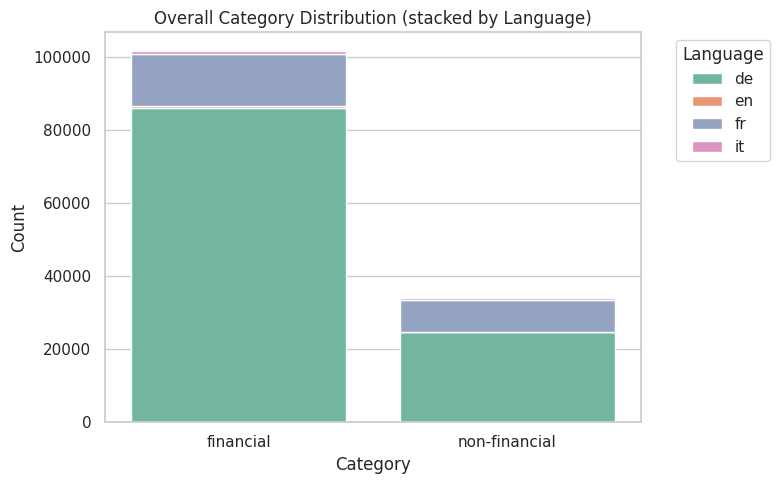

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1️⃣ Count combinations of category × language
counts = (
    df.groupby(["category", "language"])
      .size()
      .reset_index(name="count")
)

# 2️⃣ Pivot to wide format for stacking
pivot = counts.pivot(index="category", columns="language", values="count").fillna(0)

# 3️⃣ Plot stacked bars manually
plt.figure(figsize=(8,5))
bottom = None
for lang in pivot.columns:
    sns.barplot(
        x=pivot.index,
        y=pivot[lang],
        color=sns.color_palette("Set2")[list(pivot.columns).index(lang)],
        label=lang,
        bottom=bottom
    )
    if bottom is None:
        bottom = pivot[lang].copy()
    else:
        bottom += pivot[lang]

plt.title("Overall Category Distribution (stacked by Language)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()





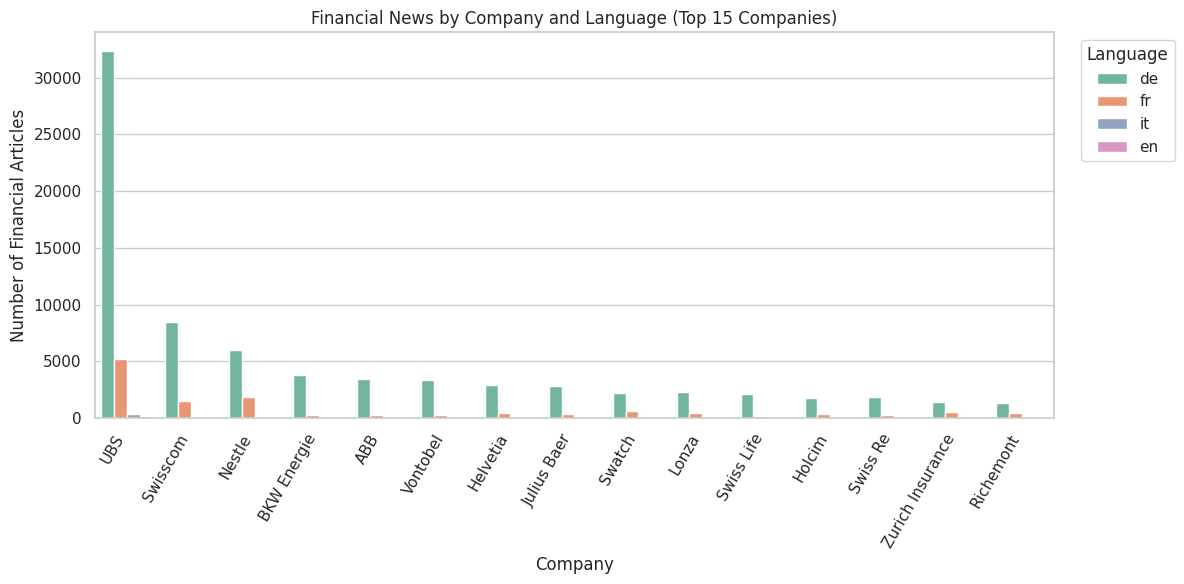

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1️⃣ Filter only financial articles
fin = df[df["category"].str.lower() == "financial"].copy()

# 2️⃣ Take top companies (you can adjust number if too many)
top_companies = fin["company"].value_counts().head(15).index
sub = fin[fin["company"].isin(top_companies)]

# 3️⃣ Plot
plt.figure(figsize=(12,6))
sns.countplot(
    data=sub,
    x="company",
    hue="language",          # ← hue = language
    order=top_companies,
    palette="Set2"
)

plt.title("Financial News by Company and Language (Top 15 Companies)")
plt.xlabel("Company")
plt.ylabel("Number of Financial Articles")
plt.xticks(rotation=60, ha="right")
plt.legend(title="Language", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1245121892.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_de  = df["language"].astype(str).str.lower().str.contains(r"^(de($|-)|ger|german)")
/tmp/ipython-input-1245121892.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fin_de["month"] = fin_de["pubtime"].dt.to_period("M").dt.to_timestamp()


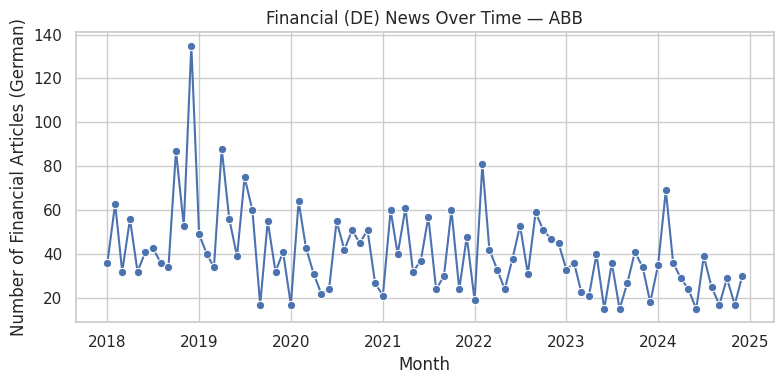

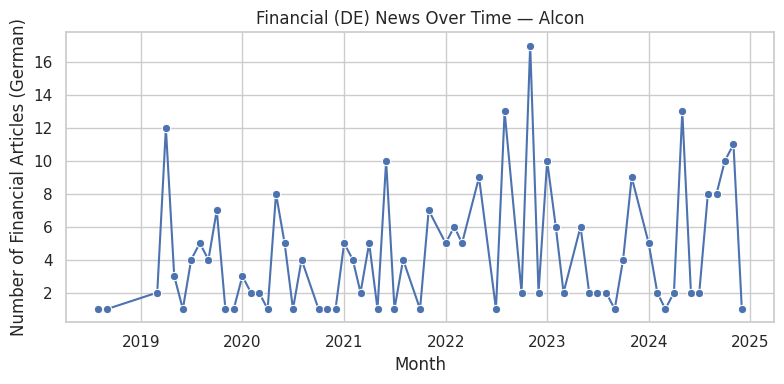

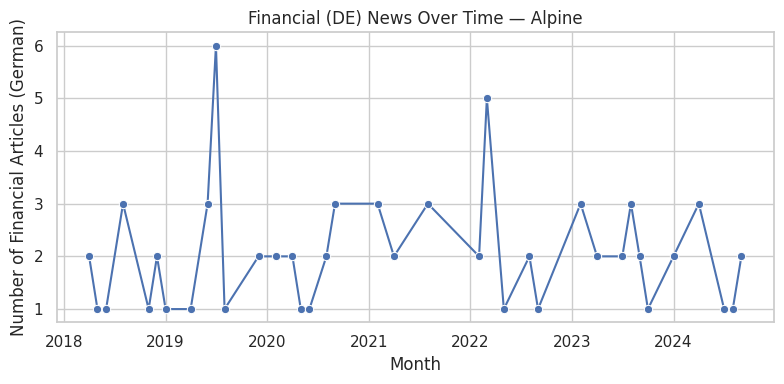

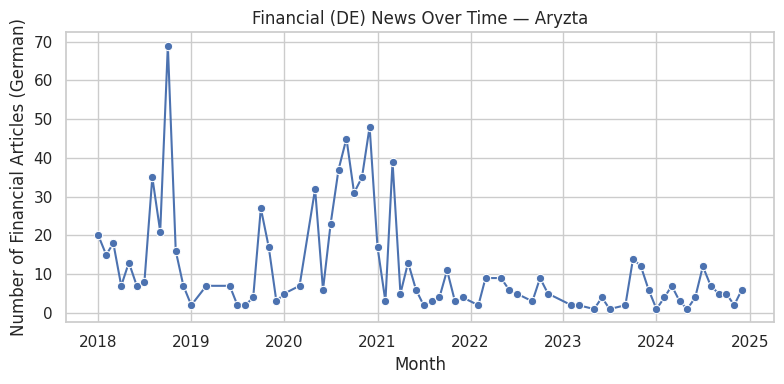

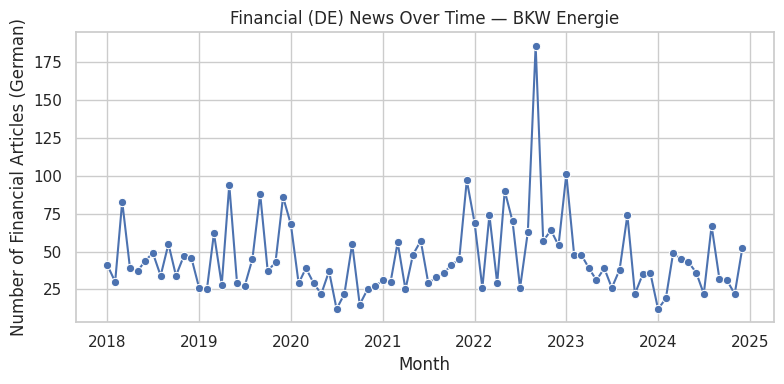

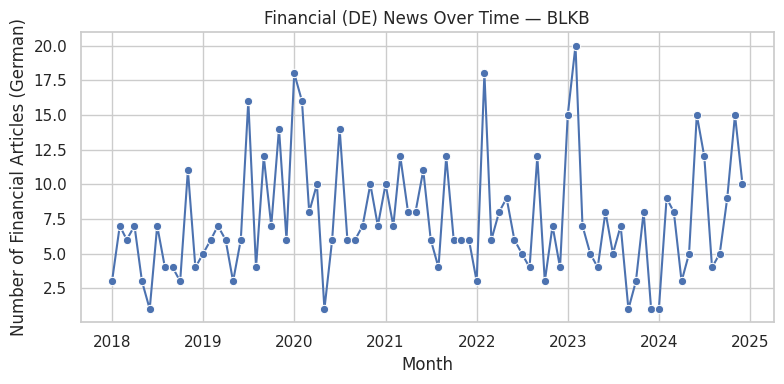

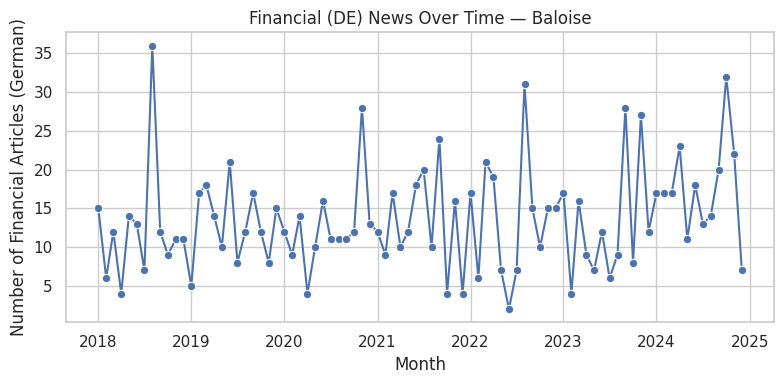

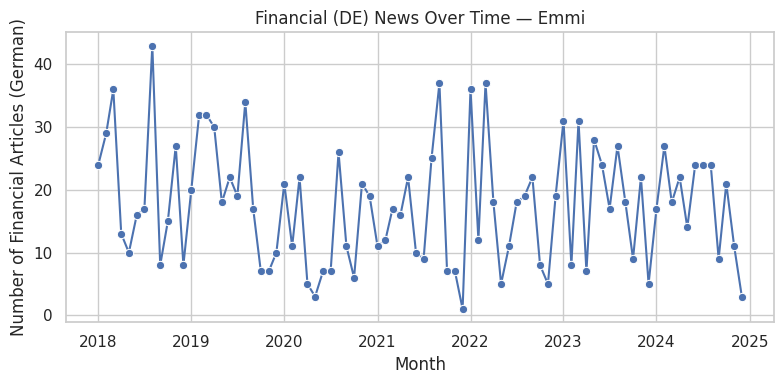

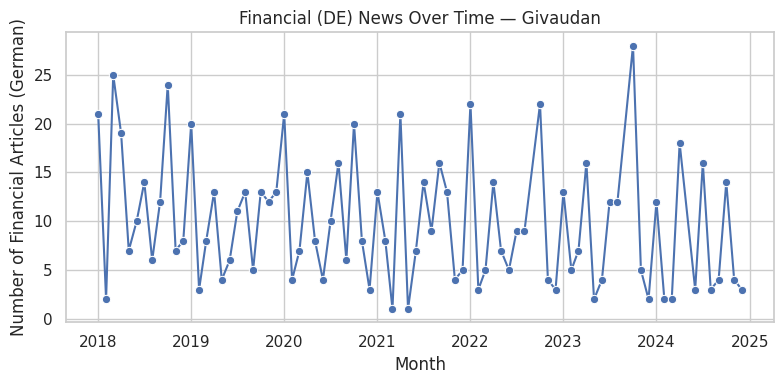

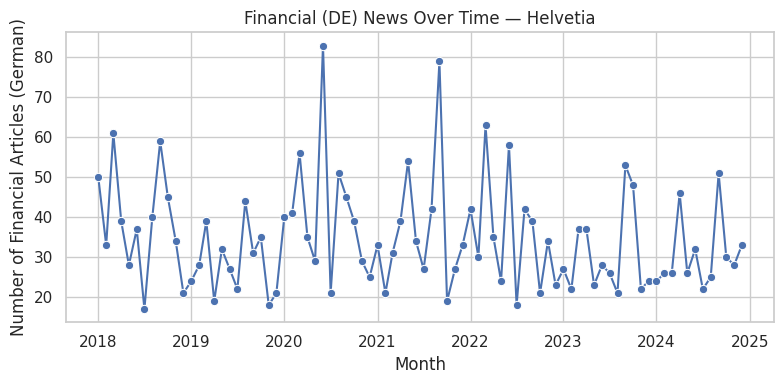

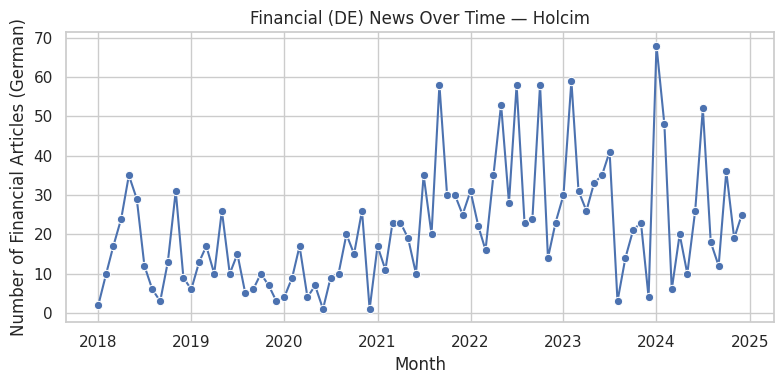

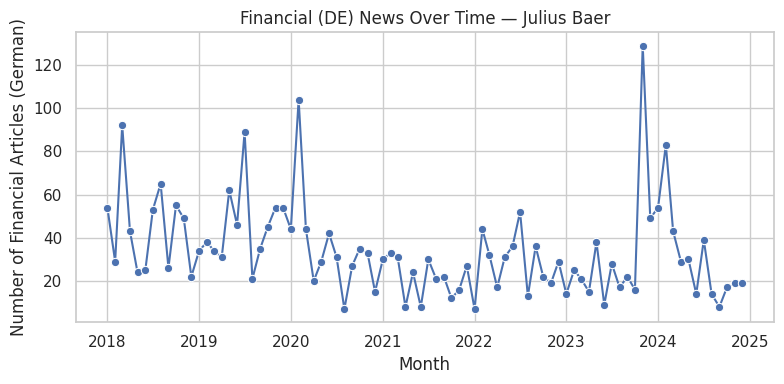

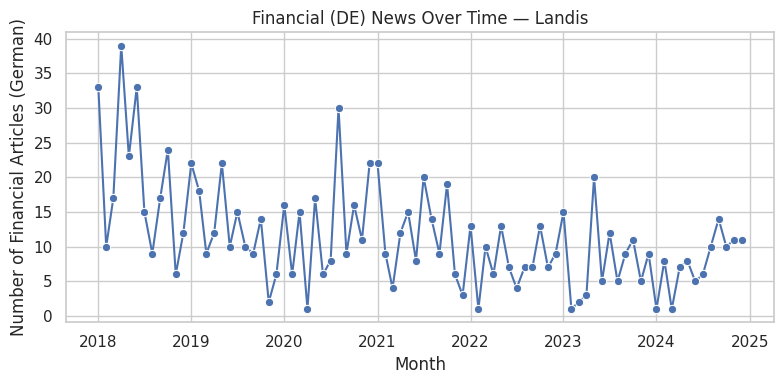

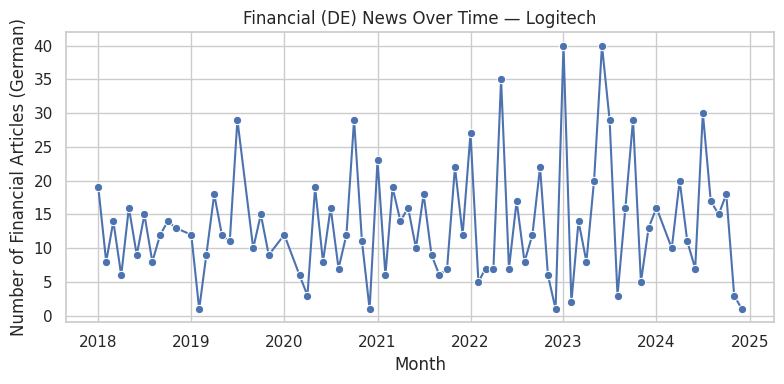

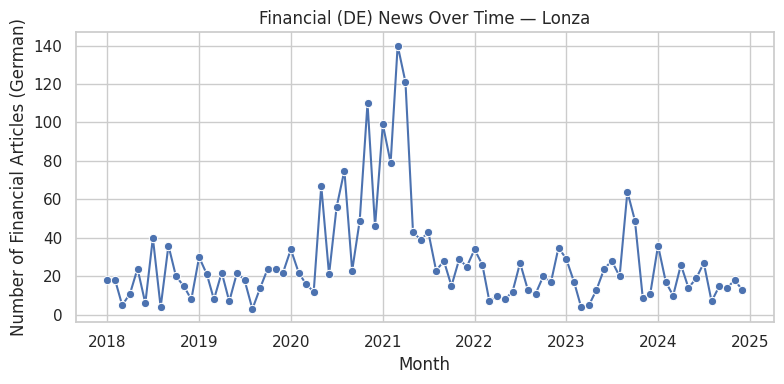

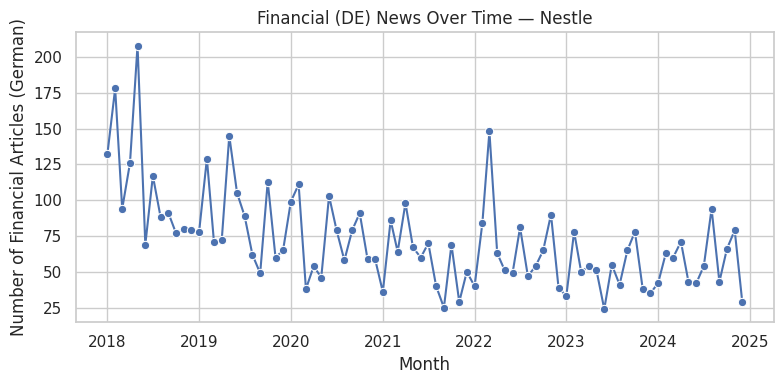

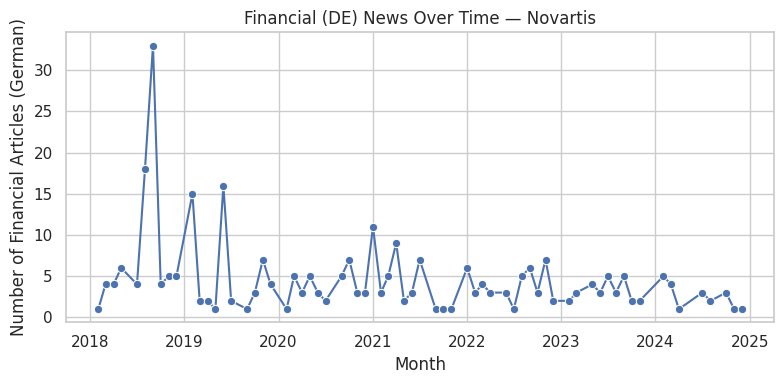

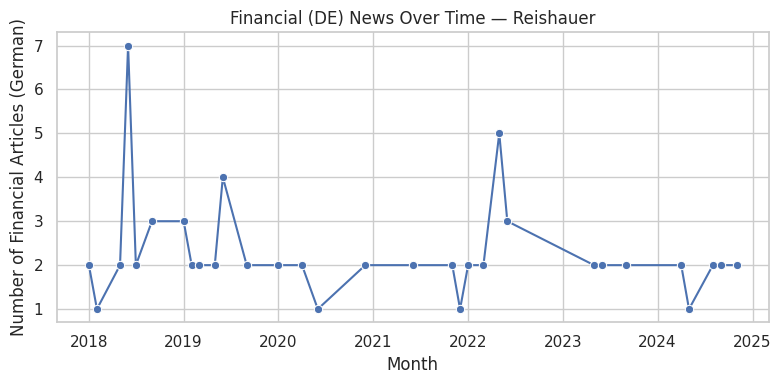

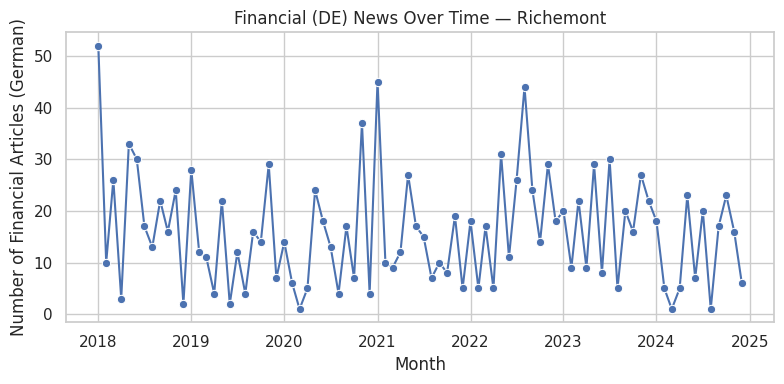

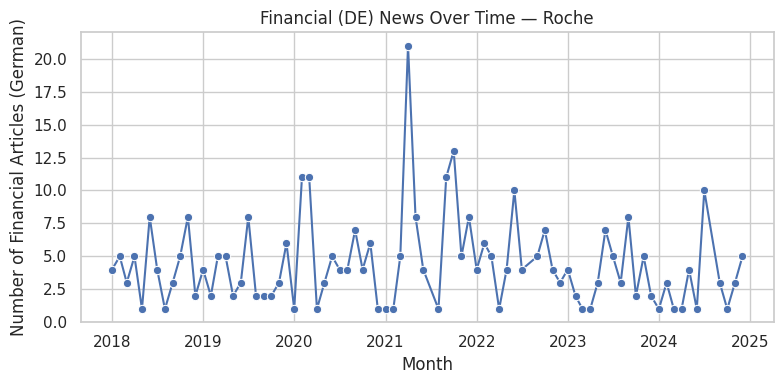

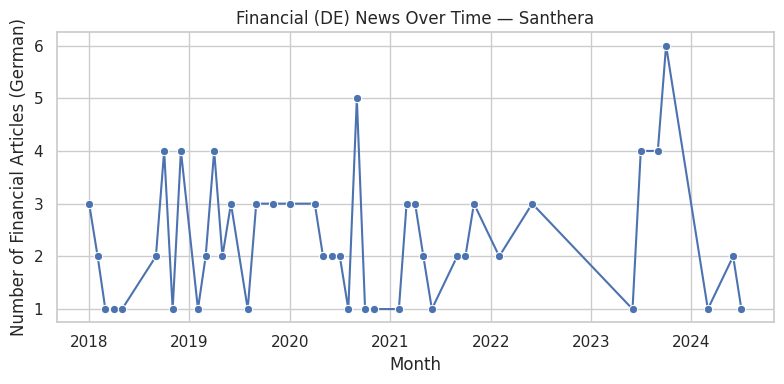

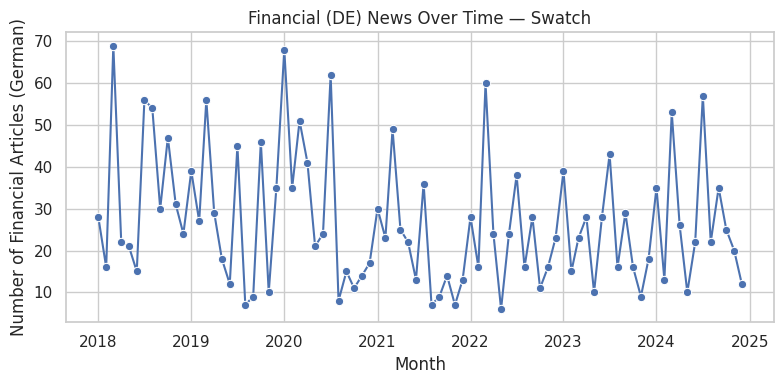

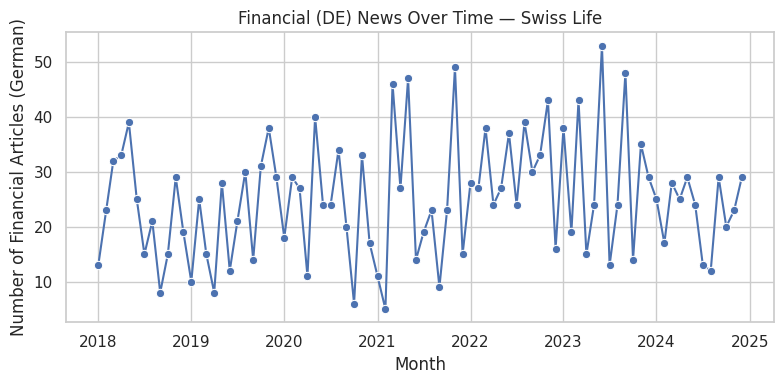

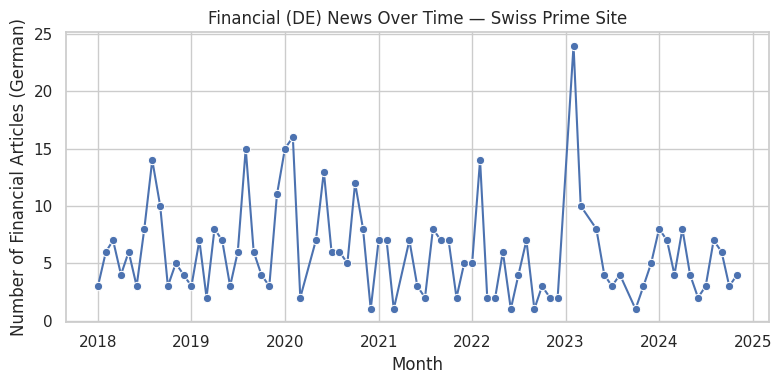

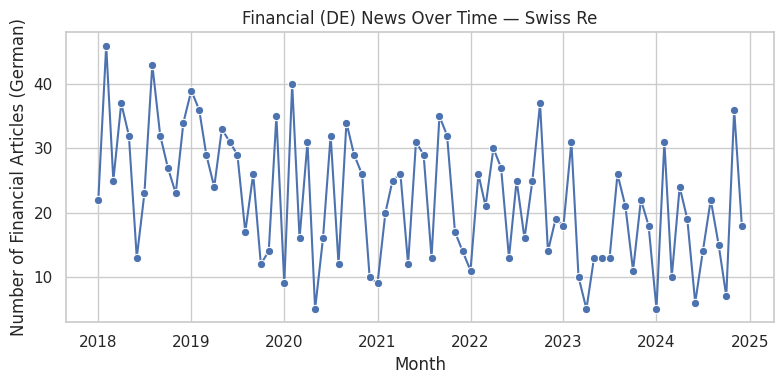

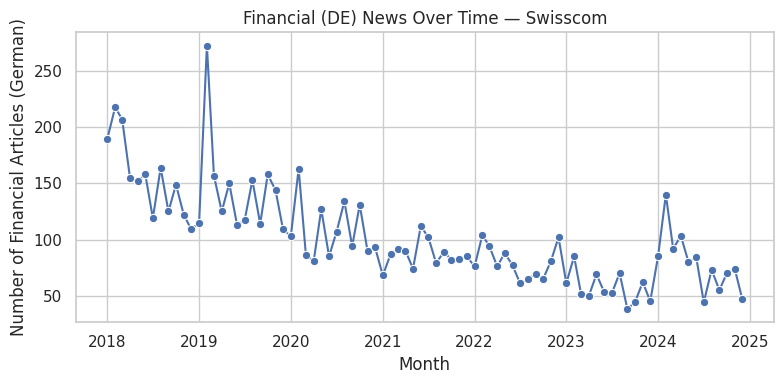

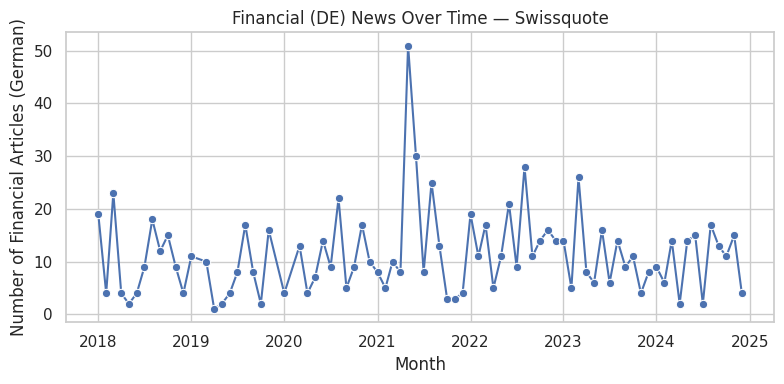

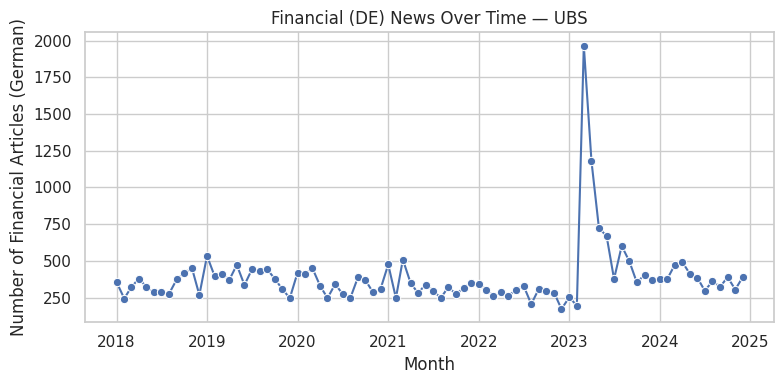

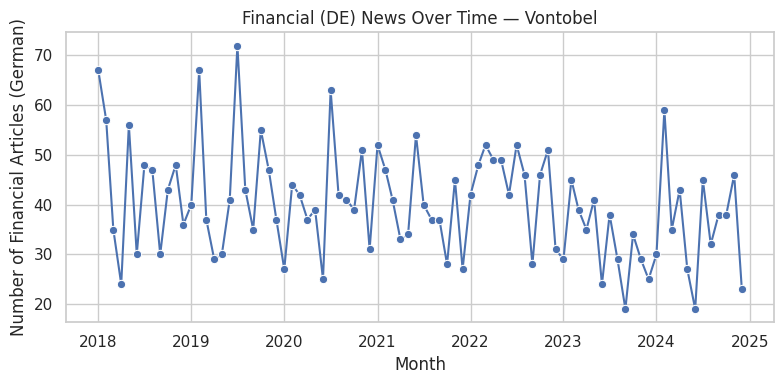

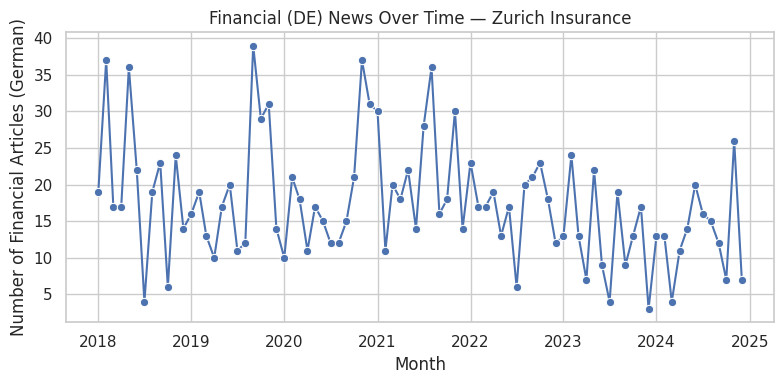

✅ Plots saved in folder: /content/drive/MyDrive/Colab Notebooks/plots_financial_each_company_DE


In [83]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme(style="whitegrid")

# 1) Ensure datetime
df["pubtime"] = pd.to_datetime(df["pubtime"], errors="coerce")

# 2) Filter: financial + German language
is_fin = df["category"].astype(str).str.lower().eq("financial")
is_de  = df["language"].astype(str).str.lower().str.contains(r"^(de($|-)|ger|german)")
fin_de = df[is_fin & is_de].copy()

# 3) Monthly bucket
fin_de["month"] = fin_de["pubtime"].dt.to_period("M").dt.to_timestamp()

# 4) Output folder
out_dir = "/content/drive/MyDrive/Colab Notebooks/plots_financial_each_company_DE"
os.makedirs(out_dir, exist_ok=True)

# 5) Iterate per company and plot
for comp, sub in fin_de.groupby("company"):
    # monthly counts
    ts = (
        sub.groupby("month")
           .size()
           .reset_index(name="count")
           .sort_values("month")
    )
    if ts.empty or len(ts) < 2:
        continue  # skip if not enough points to plot a line

    plt.figure(figsize=(8,4))
    sns.lineplot(data=ts, x="month", y="count", marker="o")
    plt.title(f"Financial (DE) News Over Time — {comp}")
    plt.xlabel("Month")
    plt.ylabel("Number of Financial Articles (German)")
    plt.tight_layout()

    # safe filename (replace spaces/slashes)
    safe_comp = re.sub(r"[\\/*?:\"<>|]", "_", str(comp)).replace(" ", "_")
    fname = f"{out_dir}/{safe_comp}_financial_DE.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

print(f"✅ Plots saved in folder: {out_dir}")



/tmp/ipython-input-911782427.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fin["year_month"] = fin["pubtime"].dt.to_period("M").astype(str)


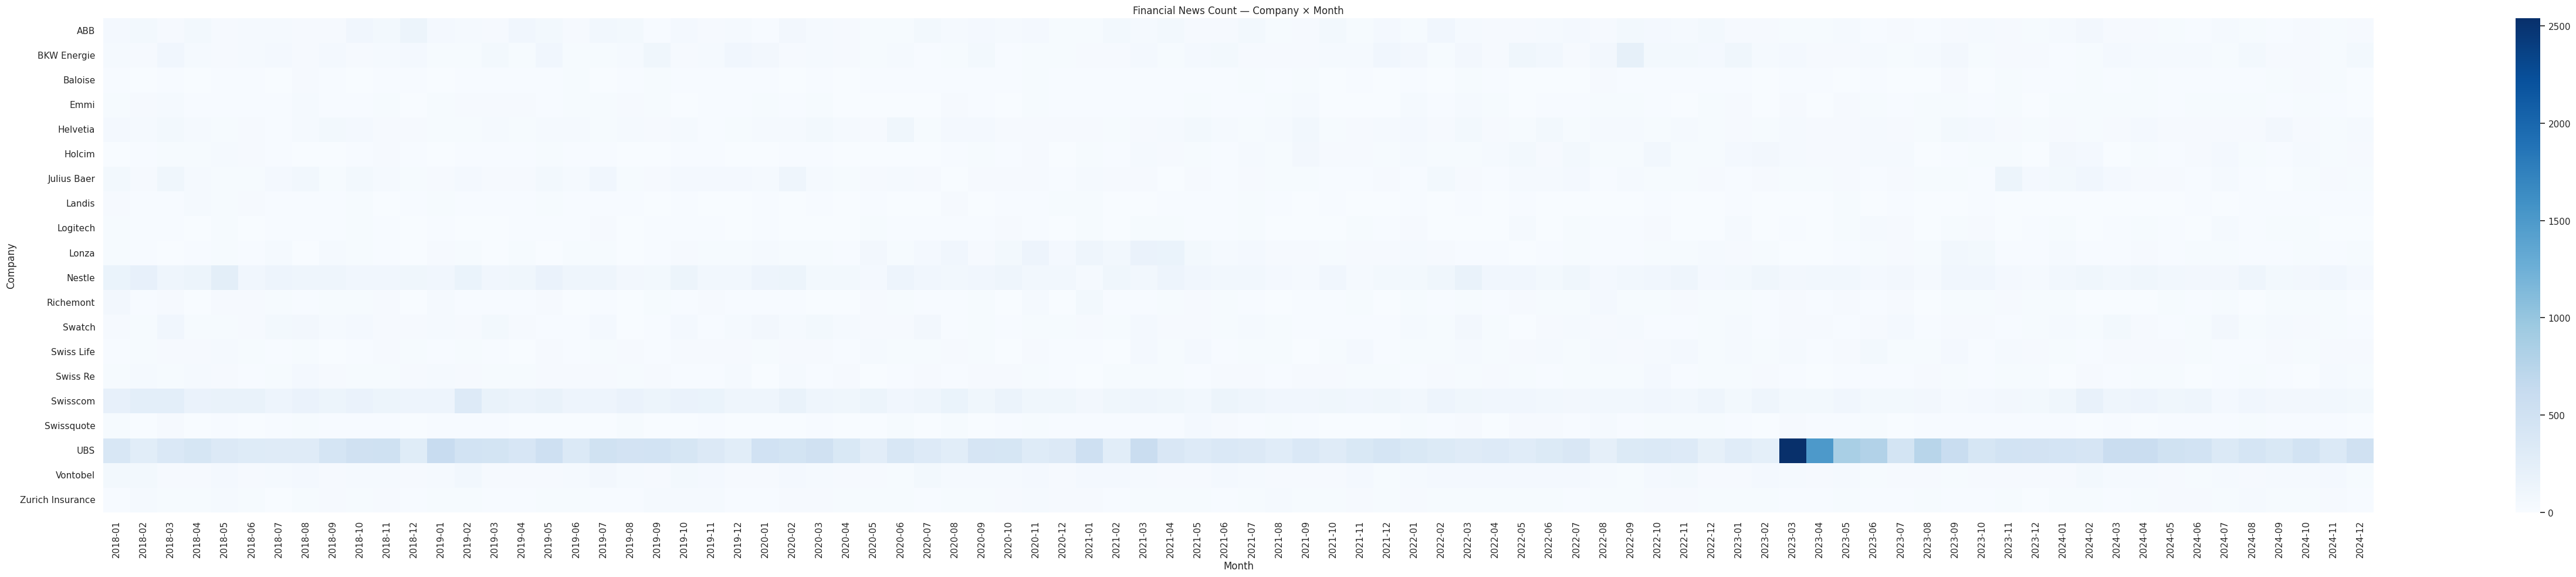

Saved -> financial_heatmap_company_month.csv


In [84]:
fin["year_month"] = fin["pubtime"].dt.to_period("M").astype(str)
TOP_N = 20
top_companies = fin["company"].value_counts().head(TOP_N).index
heat = (fin[fin["company"].isin(top_companies)]
        .pivot_table(index="company", columns="year_month",
                     values="category", aggfunc="count", fill_value=0))

plt.figure(figsize=(max(8,0.6*heat.shape[1]), 0.4*heat.shape[0]+2))
sns.heatmap(heat, cmap="Blues")
plt.title("Financial News Count — Company × Month")
plt.xlabel("Month"); plt.ylabel("Company")
plt.tight_layout(); plt.show()

heat.to_csv("/content/drive/MyDrive/Colab Notebooks/financial_heatmap_company_month.csv")
print("Saved -> financial_heatmap_company_month.csv")


/tmp/ipython-input-2837325103.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["category"]


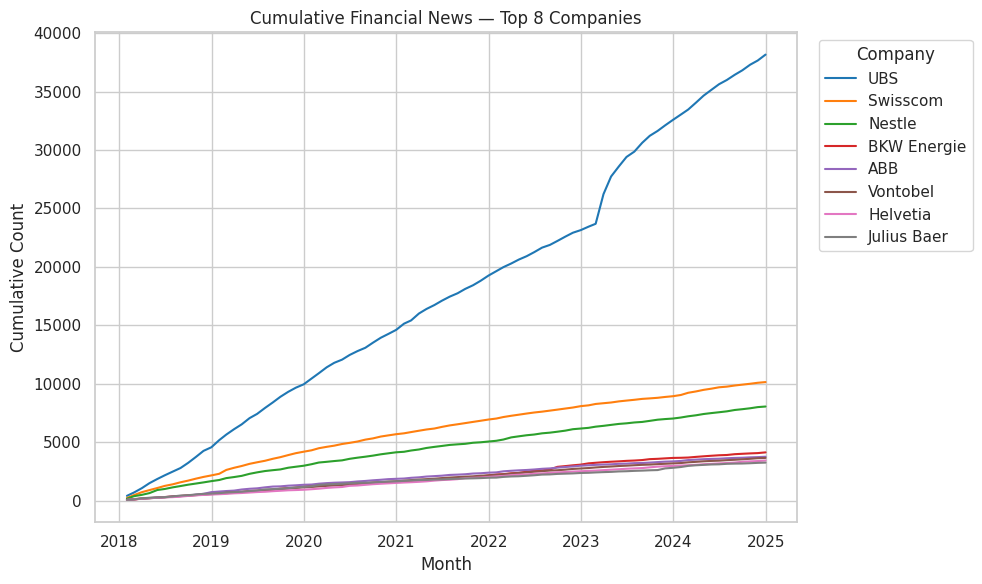

In [85]:
from itertools import cycle

top_fin = fin["company"].value_counts().head(8).index
plt.figure(figsize=(10,6))
palette = cycle(sns.color_palette("tab10"))

for comp, color in zip(top_fin, palette):
    ts = (fin[fin["company"]==comp]
          .set_index("pubtime")
          .resample("M")["category"]
          .count()
          .cumsum())
    plt.plot(ts.index, ts.values, label=comp, color=color)

plt.title("Cumulative Financial News — Top 8 Companies")
plt.xlabel("Month"); plt.ylabel("Cumulative Count")
plt.legend(title="Company", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()
